## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [1]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

!pip3 install gdown


import gdown
# train
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

'items.csv'

In [3]:
import pandas as pd
pd.read_csv('users.csv')

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [1]:
import pandas as pd
import numpy as np

In [33]:
train = pd.read_csv('train.csv')

In [3]:
train['last_watch_dt'] = (pd.to_datetime(train['last_watch_dt']) - pd.to_datetime(train['last_watch_dt']).min())
train['last_watch_dt'] = train.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
902773,528555,6738,53,11565,100.0,1
2749632,284076,15297,110,34064,100.0,1
2874829,458270,15297,112,117979,100.0,1
284752,1010539,5365,20,16289,100.0,1
4087075,1087815,6006,138,2252,0.0,0


<Axes: >

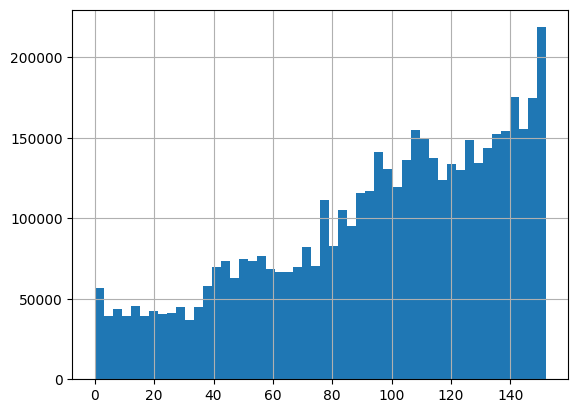

In [4]:
train.last_watch_dt.hist(bins=50)

In [5]:
train.last_watch_dt.max()

152

In [6]:
train_stage_1 = train.loc[(train.last_watch_dt < 152-7)].copy()
valid_stage_1 = train.loc[(train.last_watch_dt >= 152-7)].copy()

train_users = train_stage_1.user_id.unique()
test_users = valid_stage_1.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  109116
число людей всего: 819278


In [34]:
train_grouped = train_stage_1.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

valid_grouped = valid_stage_1.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()


valid_grouped.rename({0:'val_interactions'}, axis=1, inplace=True)

train_grouped.head()

/tmp/ipykernel_177725/88554377.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_stage_1.groupby('user_id').apply(
/tmp/ipykernel_177725/88554377.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_grouped = valid_stage_1.groupby('user_id').apply(


,user_id,train_interactions
0,0,"[(12192, 125), (15297, 128), (7102, 128), (972..."
1,2,"[(7571, 68), (11577, 69), (16166, 69), (4436, ..."
2,3,"[(2657, 82), (3734, 131), (9728, 132), (9550, ..."
3,4,"[(6317, 81), (4700, 111)]"
4,5,"[(6445, 79), (5115, 79), (12466, 89), (632, 89..."


In [35]:
joined = train_grouped.merge(valid_grouped)
joined.head()

,user_id,train_interactions,val_interactions
0,3,"[(2657, 82), (3734, 131), (9728, 132), (9550, ...","[(12192, 151), (15719, 151), (6208, 152)]"
1,14,"[(10440, 109)]","[(1204, 152)]"
2,17,"[(3734, 141)]","[(8618, 146), (10196, 146)]"
3,23,"[(10440, 144), (1916, 144)]","[(13865, 145)]"
4,30,"[(4740, 88), (676, 91), (12418, 98), (9728, 10...","[(16484, 151), (3031, 151)]"


In [3]:
from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares
from typing import List, Union, Dict

from models import ALSModel, TopPopular, TopPopularWeighted, recommend_with_fallback, recall_metric, dcg, ndcg_metric, evaluate_recommender

### Heuristic Top Popular Weighted

In [38]:
my_heuristic_model = TopPopularWeighted(min_window=14)
my_heuristic_model.fit(joined)
joined['toppopular_w_recs'] = my_heuristic_model.predict(joined, return_scores=True, topn=40)

In [18]:
evaluate_recommender(joined,  model_preds='toppopular_w_recs')

{'ndcg': 0.2509321653292127, 'recall': 0.18031416929329225}

### MF EASE

In [42]:
item2id = {k: v for v, k in enumerate(train_stage_1.item_id.unique())}
user2id = {k:v for v, k in enumerate(train_stage_1.user_id.unique())}

id2item = {k:v for v, k in item2id.items()}
id2user = {k:v for v, k in user2id.items()}

train_stage_1['user_id'] = train_stage_1.user_id.apply(lambda x: user2id[x])
train_stage_1['item_id'] = train_stage_1.item_id.apply(lambda x: item2id[x])

train_stage_1.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
2227236,428330,12491,98,14706,75.0,1
3364127,657135,599,123,4,0.0,0
3445476,444350,13910,125,4681,86.0,1
1260780,7022,589,69,13530,100.0,1
3058127,328391,11151,116,860,14.0,0


In [43]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(train_stage_1.shape[0]), (train_stage_1['user_id'], train_stage_1['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<819278x15230 sparse matrix of type '<class 'numpy.float64'>'
	with 4422775 stored elements in COOrdinate format>

In [44]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole

def fit_ease(X, reg_weight=2000):
    
    # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix)

CPU times: user 9min 28s, sys: 11.7 s, total: 9min 40s
Wall time: 56.6 s


In [45]:
w.shape

(15230, 15230)

In [46]:
def get_preds(x, item2id, id2item):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id)) # n_items
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf # n_items

    items_final = np.argsort(-preds)
    decoded = [(id2item[t], preds[t]) for t in items_final][:40]
    
    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))

In [27]:
evaluate_recommender(joined,  model_preds='ease_preds')

{'ndcg': 0.44191133749701156, 'recall': 0.3350262367004664}

### DL

In [28]:
#pip install rectools

In [47]:
import torch
import rectools
from rectools.models import SASRecModel
from rectools.dataset import Interactions, Dataset

In [48]:
print(rectools.__version__)

0.12.0


In [49]:
torch.cuda.init()
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3090


In [50]:
exploded = joined[["user_id", "train_interactions"]].explode("train_interactions").copy()
exploded["item_id"] = exploded["train_interactions"].apply(lambda x: x[0])
exploded["timestamp"] = exploded["train_interactions"].apply(lambda x: x[1])
exploded = exploded[["user_id", "item_id", "timestamp"]]

In [51]:
df_for_recs = exploded.rename(columns={
    "user_id": "user_id",
    "item_id": "item_id",
    "timestamp": "datetime" 
}).copy()

df_for_recs["weight"] = 1.0

In [52]:
sas_dataset = Dataset.construct(interactions_df=df_for_recs)

sas_model = SASRecModel(dataloader_num_workers=11)

sas_model.fit(sas_dataset)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lit-player/venv/lib/python3.12/site-packages/rectools/dataset/identifiers.py:60: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unq_values = pd.unique(values)
/home/lit-player/venv/lib/python3.12/site-packages/rectools/models/nn/item_net.py:129: UserWarning: Ignoring `CatFeaturesItemNet` block because dataset doesn't contain item features.
  warnings.warn(explanation)
/home/lit-player/venv/lib/python3.12/site-packages/pydantic/main.py:453: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=('rectools.models.nn.item...net.CatFeaturesItemNet'), input_type=tuple])
  return self.__pydantic_serializer__.to_python(
/home/lit-player/venv/lib/python3.12/site-packages/pytor

In [64]:
top_pop = TopPopular()
top_pop.fit(joined)

In [66]:
sas_scores_df = recommend_with_fallback(sas_model, fallback_model=top_pop, dataset=sas_dataset, k=40, user_ids=joined["user_id"].tolist())

sas_scores_tuples = (
    sas_scores_df
    .groupby('user_id')
    .apply(lambda df: list(zip(df['item_id'], df['score'])))
    .to_dict()
)

joined['sasrec'] = joined['user_id'].map(sas_scores_tuples)

/home/lit-player/venv/lib/python3.12/site-packages/rectools/models/nn/transformers/data_preparator.py:332: UserWarning: 11 target users were considered cold because of missing known items
  warnings.warn(explanation)
/tmp/ipykernel_177725/841015679.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: list(zip(df['item_id'], df['score'])))


In [67]:
joined

,user_id,train_interactions,val_interactions,toppopular_w_recs,ease_preds,sasrec
0,3,"[(2657, 82), (3734, 131), (9728, 132), (9550, ...","[(12192, 151), (15719, 151), (6208, 152)]","[(9728, 0.026961073936162903), (10440, 0.02398...","[(10440, 0.668121267152341), (15297, 0.5683381...","[(15297, 3.1293845176696777), (7829, 3.1090271..."
1,14,"[(10440, 109)]","[(1204, 152)]","[(9728, 0.026961073936162903), (10440, 0.02398...","[(15297, 0.1466464659153043), (13865, 0.091005...","[(15297, 5.820451736450195), (9728, 5.13982677..."
2,17,"[(3734, 141)]","[(8618, 146), (10196, 146)]","[(9728, 0.026961073936162903), (10440, 0.02398...","[(13865, 0.10928726121998848), (9728, 0.105550...","[(15297, 5.087735176086426), (9728, 4.76997613..."
3,23,"[(10440, 144), (1916, 144)]","[(13865, 145)]","[(9728, 0.026961073936162903), (10440, 0.02398...","[(15297, 0.20769040249721638), (13865, 0.11644...","[(15297, 5.091784477233887), (9728, 4.69442462..."
4,30,"[(4740, 88), (676, 91), (12418, 98), (9728, 10...","[(16484, 151), (3031, 151)]","[(9728, 0.026961073936162903), (10440, 0.02398...","[(13865, 0.18249275534722792), (3734, 0.125158...","[(5505, 2.8855514526367188), (7829, 2.85427355..."
...,...,...,...,...,...,...
109111,1097512,"[(3734, 144), (10440, 144)]","[(13941, 149), (1819, 149), (12192, 152)]","[(9728, 0.026961073936162903), (10440, 0.02398...","[(15297, 0.23370605235583472), (13865, 0.20029...","[(15297, 5.329156875610352), (9728, 4.83241224..."
109112,1097513,"[(4436, 35), (5693, 39), (7932, 39), (8801, 39...","[(8424, 147), (8387, 147), (6577, 150), (141, ...","[(9728, 0.026961073936162903), (10440, 0.02398...","[(9728, 1.3801023410173923), (13865, 0.8549089...","[(7793, 4.115230083465576), (12259, 3.08332610..."
109113,1097521,"[(11756, 118), (9194, 120), (14, 122), (3133, ...","[(4151, 146)]","[(9728, 0.026961073936162903), (10440, 0.02398...","[(15297, 0.24650392999031534), (9728, 0.220336...","[(9728, 3.7119688987731934), (10440, 3.3589899..."
109114,1097534,"[(13865, 83), (7107, 83), (10440, 83), (2657, ...","[(142, 151)]","[(9728, 0.026961073936162903), (10440, 0.02398...","[(10440, 0.9548769135843478), (15297, 0.641304...","[(12192, 4.177574157714844), (3734, 4.08195924..."


In [36]:
evaluate_recommender(joined.dropna(),  model_preds='sasrec_scores')

{'ndcg': 0.4381256854996394, 'recall': 0.3337682858847864}

In [69]:
from tqdm import tqdm
new_rows = []

for _, row in tqdm(joined.iterrows()):
    test_items = set(row.val_interactions[0]) if row.val_interactions else set()

    ease_dict = dict(row.ease_preds)
    top_dict = dict(row.toppopular_w_recs)
    sas_dict = dict(row.sasrec)

    all_items = set(ease_dict) | set(top_dict) | set(sas_dict)

    for item in all_items:
        new_rows.append({
            "user_id": row.user_id,
            "item_id": item,
            "ease_score": ease_dict.get(item),
            "top_score": top_dict.get(item),
            "sasrec_score": sas_dict.get(item),
            "label": int(item in test_items),
        })

new_ds = pd.DataFrame(new_rows)

109116it [00:38, 2840.09it/s]


In [75]:
new_ds = new_ds.fillna(0)

In [78]:
new_ds

,user_id,item_id,ease_score,top_score,sasrec_score,label
0,3,9728,0.491548,0.026961,0.000000,0
1,3,10240,0.078507,0.000000,2.090201,0
2,3,3076,0.000000,0.000000,1.774166,0
3,3,1290,0.000000,0.003152,1.649431,0
4,3,9996,0.251372,0.005350,2.498025,0
...,...,...,...,...,...,...
8381996,1097544,13262,0.000000,0.000000,1.553211,0
8381997,1097544,9169,0.026996,0.000000,0.000000,0
8381998,1097544,10464,0.045625,0.000000,0.000000,0
8381999,1097544,4331,0.027637,0.000000,0.000000,0


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [12]:
users = pd.read_csv('users.csv')
items = pd.read_csv('items.csv')

In [13]:
uf1 = train_stage_1.groupby('user_id')['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'user_avg_watch_pct'})
uf2 = train_stage_1.groupby('user_id')['last_watch_dt'].agg(['nunique', 'count']).reset_index()
uf2['user_avg_movies_per_day'] = uf2['count'] / uf2['nunique']
uf2 = uf2[['user_id', 'user_avg_movies_per_day']]

uf_df = uf1.merge(uf2, on='user_id')

In [14]:
uf_df

,user_id,user_avg_watch_pct,user_avg_movies_per_day
0,0,0.833333,2.000000
1,2,83.877551,1.960000
2,3,52.210526,2.111111
3,4,48.500000,1.000000
4,5,9.764706,5.666667
...,...,...,...
819273,1097553,1.000000,4.000000
819274,1097554,90.000000,1.111111
819275,1097555,10.714286,1.400000
819276,1097556,23.000000,1.000000


In [15]:
if1 = train_stage_1.groupby('item_id')['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'item_avg_watch_prct'})

if2 = train_stage_1.groupby('item_id')['user_id'].nunique().reset_index().rename(columns={'user_id': 'item_unique_users'})

if_df = if1.merge(if2, on='item_id')

In [16]:
items.genres.unique()

array(['драмы, зарубежные, детективы, мелодрамы',
       'зарубежные, приключения, комедии',
       'криминал, зарубежные, триллеры, боевики, комедии', ...,
       'детективы, драмы, зарубежные, триллеры, фантастика, ужасы',
       'фэнтези, семейное, русские, для детей',
       'фэнтези, семейное, криминал, комедии'], dtype=object)

In [17]:
train_stage_1

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,0,4485,98.0,1
1,952323,15997,0,7507,100.0,1
2,889459,11460,0,60,0.0,0
3,854016,11237,0,5381,98.0,1
4,307257,9132,0,5814,100.0,1
...,...,...,...,...,...,...
4422770,765454,9728,144,2229,33.0,0
4422771,530370,1699,144,4622,13.0,0
4422772,740941,5650,144,484,9.0,0
4422773,979557,9728,144,2327,34.0,0


In [18]:
train_stage_1[train_stage_1.user_id.isin(all_included)]

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
2,889459,11460,0,60,0.0,0
14,713914,14230,0,3552,51.0,1
15,382278,11494,0,4908,100.0,1
19,671628,12637,0,5573,100.0,1
20,1017494,3220,0,2531,46.0,0
...,...,...,...,...,...,...
4422766,137353,6443,144,23,0.0,0
4422768,627385,12324,144,611,9.0,0
4422770,765454,9728,144,2229,33.0,0
4422772,740941,5650,144,484,9.0,0


In [ ]:
uif_df = train_stage_1[train_stage_1.user_id.isin(all_included)]

uif_df = uif_df.merge(uf_df, on='user_id', how='left')
uif_df = uif_df.merge(if_df, on='item_id', how='left')
uif_df = uif_df.merge(users, on='user_id', how='left')
uif_df = uif_df.merge(items, on='item_id', how='left')

# 1. Совпадает ли пол пользователя и целевой аудитории
uif_df['gender_match'] = (uif_df['sex'] == 'F') & (uif_df['genres'].str.contains('мелодрам|драм|трилл|ужас')).fillna('0').astype(int)

# 2. Соответствие возрастного рейтинга фильма и возраста пользователя
uif_df['age_match'] = uif_df.apply(lambda x: int(x['age_rating'] <= 12 and (pd.isna(x['age']) or 'age_18_24' not in str(x['age']))), axis=1)

# 3. Смотрел ли пользователь ранее фильм такой же студии
user_studios = train_stage_1.merge(items[['item_id', 'studios']], on='item_id')\
    .groupby(['user_id', 'studios']).size().reset_index(name='watched')

uif_df = uif_df.merge(user_studios[['user_id', 'studios', 'watched']], 
                                      on=['user_id', 'studios'], how='left')

uif_df['watched_same_studio_before'] = (uif_df['watched'] > 1).fillna(0).astype(int)
uif_df.drop(columns=['watched'], inplace=True)

# 4. Смотрел ли пользователь ранее фильм с тем же актером
actors_expanded = items[['item_id', 'actors']].dropna().assign(actor=lambda df: df['actors'].str.split(",")).explode('actor')
user_actors = train_stage_1.merge(actors_expanded, on='item_id')\
    .groupby(['user_id', 'actor']).size().reset_index(name='watched_actor')

uif_df = uif_df.merge(actors_expanded, on='item_id', how='left')
uif_df = uif_df.merge(user_actors[['user_id', 'actor', 'watched_actor']], 
                                      on=['user_id', 'actor'], how='left')

uif_df['watched_same_actor_before'] = (uif_df['watched_actor'] > 1).fillna(0).astype(int)
uif_df.drop(columns=['watched_actor', 'actor'], inplace=True)

# 5. Доля детских фильмов среди просмотренных пользователем
kids_films = train_stage_1.merge(items[['item_id', 'for_kids']], on='item_id')\
                         .groupby('user_id')['for_kids'].mean().reset_index().rename(columns={'for_kids': 'user_kids_films_share'})

uif_df = uif_df.merge(kids_films, on='user_id', how='left')

# 6. Пользователь ранее смотрел фильмы такого же жанра
item_genres_exp = items[['item_id', 'genres']].assign(genre=lambda df: df['genres'].str.split(",")).explode('genre')
user_genres = train_stage_1.merge(item_genres_exp, on='item_id')\
                .groupby(['user_id', 'genre']).size().reset_index(name='genre_watch_count')

uif_df = uif_df.merge(item_genres_exp, on='item_id', how='left')\
                               .merge(user_genres, on=['user_id', 'genre'], how='left')

uif_df['watched_same_genre_before'] = (uif_df['genre_watch_count'] > 1).fillna(0).astype(int)
uif_df.drop(columns=['genre_watch_count', 'genre'], inplace=True)

final_features_df = uif_df


In [22]:
final_features_df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,user_avg_watch_pct,user_avg_movies_per_day,item_avg_watch_prct,item_unique_users,...,description,keywords,gender_match,age_match,watched_same_studio_before,actors_y,watched_same_actor_before,user_kids_films_share,genres_y,watched_same_genre_before
24234231,403740,11749,130,11667,100.0,1,73.578947,1.461538,59.667472,4553,...,После событий первой части суперсемейка пользу...,"семейная пара, продолжение, супергерой, дети, ...",False,1,0,"Крэйг Т. Нельсон, Холли Хантер, Сара Вауэлл, Х...",1,NaN,"фантастика, мультфильм, приключения",1
12395853,182469,11778,96,16988,100.0,1,50.762712,1.787879,59.012139,10627,...,"Режиссёрка Нэнси Майерс, известная благодаря ф...","Нью-Йорк, отель, жених, выпускной, бывший муж,...",False,0,0,"Мэрил Стрип, Алек Болдуин, Стив Мартин, Джон К...",0,NaN,"драмы, мелодрамы, комедии",1
25567147,691826,15297,133,39083,75.0,1,72.777778,1.800000,55.995623,160852,...,"Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча...",False,0,0,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...",0,0.0,"драмы, мелодрамы",0
13491999,275353,10983,100,128,2.0,0,17.090361,3.569892,43.080645,310,...,Три сексоголика решили бороться с пагубной зав...,"секс-терапия, сексуальная зависимость, романти...",False,0,0,"Марк Руффало, Тим Роббинс, Гвинет Пэлтроу, Джо...",0,NaN,"драмы, мелодрамы, комедии",1
1171548,340483,9937,16,10045,100.0,1,59.384181,3.105263,51.074876,2818,...,Соломон Нортап был женатым и образованным мужч...,"рабство, плантация, на основе мемуаров или авт...",False,0,0,"Чиветел Эджиофор, Маркус Лайл Браун, Пол Джама...",0,NaN,"драмы, биография, историческое",1


In [23]:
final_features_df.columns

Index(['user_id', 'item_id', 'last_watch_dt', 'total_dur', 'watched_pct',
       'target', 'user_avg_watch_pct', 'user_avg_movies_per_day',
       'item_avg_watch_prct', 'item_unique_users', 'age', 'income', 'sex',
       'kids_flg', 'content_type', 'title', 'title_orig', 'release_year',
       'genres_x', 'countries', 'for_kids', 'age_rating', 'studios',
       'directors', 'actors_x', 'description', 'keywords', 'gender_match',
       'age_match', 'watched_same_studio_before', 'actors_y',
       'watched_same_actor_before', 'user_kids_films_share', 'genres_y',
       'watched_same_genre_before'],
      dtype='object')

In [99]:
train_df_with_features = final_features_df[['user_id', 'item_id','gender_match', 'user_avg_watch_pct',
                                            'user_avg_movies_per_day','item_avg_watch_prct',
                                            'item_unique_users', 'age_match', 'watched_same_studio_before',
                                            'watched_same_actor_before', 'user_kids_films_share', 'watched_same_genre_before']]

In [91]:
train_df_with_features.sample(5)

,user_id,item_id,gender_match,user_avg_watch_pct,user_avg_movies_per_day,item_avg_watch_prct,item_unique_users,age_match,watched_same_studio_before,actors_y,watched_same_actor_before,user_kids_films_share,genres_y,watched_same_genre_before
17566756,601062,14388,False,45.250000,2.000000,83.411972,284,1,0,"Пэттон Освальт, Кевин Харт, Харрисон Форд, Эри...",0,NaN,"мультфильм, приключения, комедии",1
13258247,25444,13921,False,51.507937,3.500000,41.080229,698,1,0,"Алессандро Гассман, Изабелла Рагонезе, Росси д...",0,NaN,"драмы, семейное, комедии",1
5863405,743396,1819,False,39.947368,1.583333,64.810722,10651,0,0,"Артем Карокозян, Артем Калайджян, Марина Калец...",0,NaN,комедии,1
26217457,18031,8801,False,30.200000,2.500000,59.223124,4065,0,0,"Леонардо ДиКаприо, Марк Руффало, Бен Кингсли, ...",0,NaN,"драмы, триллеры, детективы",0
13819768,82844,4696,False,79.974359,2.000000,64.015673,3573,1,0,"Роберт Дауни мл., Антонио Бандерас, Майкл Шин,...",1,NaN,"семейное, фэнтези, приключения, комедии",1


In [84]:
valid_stage_1.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
4577123,354093,3931,147,3048,42.0,0
4816039,786509,13865,152,2332,37.0,0
4803613,953008,9298,151,2507,32.0,0
4792262,298801,2568,151,6571,100.0,1
4439137,635140,15297,145,14204,88.0,1


In [100]:
user_features = train_df_with_features[["user_id", "user_avg_watch_pct", "user_avg_movies_per_day"]].drop_duplicates()
item_features = train_df_with_features[["item_id", "item_avg_watch_prct", "item_unique_users"]].drop_duplicates()
ui_features = train_df_with_features[[
    "user_id", "item_id", 
    "gender_match", "age_match", 
    "watched_same_studio_before", "watched_same_actor_before", 
    "user_kids_films_share", "watched_same_genre_before"
]].drop_duplicates()

In [101]:
valid_df_with_features = valid_stage_1.copy()

valid_df_with_features = valid_df_with_features.merge(user_features, on="user_id", how="left")

valid_df_with_features = valid_df_with_features.merge(item_features, on="item_id", how="left")

valid_df_with_features = valid_df_with_features.merge(ui_features, on=["user_id", "item_id"], how="left")

In [102]:
valid_df_with_features = valid_df_with_features[['user_id', 'item_id','gender_match', 'user_avg_watch_pct',
                                            'user_avg_movies_per_day','item_avg_watch_prct',
                                            'item_unique_users', 'age_match', 'watched_same_studio_before',
                                            'watched_same_actor_before', 'user_kids_films_share', 'watched_same_genre_before']]

In [103]:
valid_df_with_features

,user_id,item_id,gender_match,user_avg_watch_pct,user_avg_movies_per_day,item_avg_watch_prct,item_unique_users,age_match,watched_same_studio_before,watched_same_actor_before,user_kids_films_share,watched_same_genre_before
0,948935,3973,NaN,53.684211,1.266667,73.000000,67.0,NaN,NaN,NaN,NaN,NaN
1,13989,12365,NaN,56.176471,1.214286,52.364162,692.0,NaN,NaN,NaN,NaN,NaN
2,78374,2816,NaN,68.444444,2.571429,57.593946,958.0,NaN,NaN,NaN,NaN,NaN
3,560520,12305,NaN,100.000000,1.000000,47.085608,806.0,NaN,NaN,NaN,NaN,NaN
4,989741,3800,NaN,63.000000,1.000000,55.387275,2169.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
444176,630581,11863,NaN,11.333333,3.000000,4.897657,10201.0,NaN,NaN,NaN,NaN,NaN
444177,1077579,6866,NaN,NaN,NaN,12.700565,354.0,NaN,NaN,NaN,NaN,NaN
444178,92438,2025,NaN,58.159574,2.410256,59.820611,262.0,NaN,NaN,NaN,NaN,NaN
444179,933989,2923,NaN,57.695652,1.437500,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
valid_df_with_features.isna().sum()

user_id                            0
item_id                            0
gender_match                  444181
user_avg_watch_pct            130633
user_avg_movies_per_day       130633
item_avg_watch_prct            16557
item_unique_users              16557
age_match                     444181
watched_same_studio_before    444181
watched_same_actor_before     444181
user_kids_films_share         444181
watched_same_genre_before     444181
dtype: int64

In [169]:
merged_df = new_ds.merge(
    valid_df_with_features,
    on=['user_id', 'item_id'], 
    how = 'left'
)

In [170]:
merged_df

,user_id,item_id,ease_score,top_score,sasrec_score,label,gender_match,user_avg_watch_pct,user_avg_movies_per_day,item_avg_watch_prct,item_unique_users,age_match,watched_same_studio_before,watched_same_actor_before,user_kids_films_share,watched_same_genre_before
0,3,9728,0.491548,0.026961,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,10240,0.078507,0.000000,2.090201,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3076,0.000000,0.000000,1.774166,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1290,0.000000,0.003152,1.649431,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,9996,0.251372,0.005350,2.498025,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8381996,1097544,13262,0.000000,0.000000,1.553211,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8381997,1097544,9169,0.026996,0.000000,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8381998,1097544,10464,0.045625,0.000000,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8381999,1097544,4331,0.027637,0.000000,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
merged_df.isna().sum()

user_id                             0
item_id                             0
ease_score                          0
top_score                           0
sasrec_score                        0
label                               0
gender_match                  8382001
user_avg_watch_pct            8267961
user_avg_movies_per_day       8267961
item_avg_watch_prct           8267961
item_unique_users             8267961
age_match                     8382001
watched_same_studio_before    8382001
watched_same_actor_before     8382001
user_kids_films_share         8382001
watched_same_genre_before     8382001
dtype: int64

In [172]:
merged_df = merged_df.fillna(-1)

/tmp/ipykernel_177725/1208344190.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.fillna(-1)



### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [173]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

val_stage_1_2, val_stage_2_2 = train_test_split(merged_df)

In [174]:
# YOUR FIT PREDICT CODE HERE
model = CatBoostClassifier(eval_metric="AUC", task_type="GPU", verbose=0)

model.fit(val_stage_1_2.drop(columns = ['label']), val_stage_1_2['label'])


Default metric period is 5 because AUC is/are not implemented for GPU


In [175]:
auc(val_stage_2_2['label'], model.predict(val_stage_2_2.drop(columns = ['label'])))

0.7186963374417523

In [180]:
import optuna
from sklearn.metrics import roc_auc_score

def objective(trial):

    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "eval_metric": "AUC",
        "task_type": "GPU",
        "verbose": False,
        "early_stopping_rounds": 50
    }

    model = CatBoostClassifier(**params)
    model.fit(val_stage_1_2.drop(columns = ['label']), val_stage_1_2['label'], eval_set=(val_stage_2_2.drop(columns = ['label']), val_stage_2_2['label']), verbose=False)

    y_pred = model.predict_proba(val_stage_2_2.drop(columns = ['label']))[:, 1]
    auc = roc_auc_score(val_stage_2_2['label'], y_pred)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-04-07 22:32:46,688] A new study created in memory with name: no-name-d28e285e-ce5b-4ad9-938d-ef94787c911f
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-04-07 22:32:53,830] Trial 0 finished with value: 0.9973622940492567 and parameters: {'learning_rate': 0.1517641640052536, 'depth': 7, 'l2_leaf_reg': 9.514992997532948, 'random_strength': 0.200548984189196}. Best is trial 0 with value: 0.9973622940492567.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-04-07 22:33:03,955] Trial 1 finished with value: 0.9973739594243849 and parameters: {'learning_rate': 0.11547081881303754, 'depth': 4, 'l2_leaf_reg': 8.166644706610127, 'random_strength': 0.001678988006211649}. Best is trial 1 with value: 0.9973739594243849.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-04-07 22:33:13,787] Trial 2 finished with value: 0.9973542694389742 and parameters: {'learning_rate': 0.05740142769792168, 'depth': 10, 'l

In [184]:
bp = study.best_params

model = CatBoostClassifier(**bp, task_type="GPU", verbose=0)

model.fit(val_stage_1_2.drop(columns = ['label']), val_stage_1_2['label'])

In [185]:
auc(val_stage_2_2['label'], model.predict(val_stage_2_2.drop(columns = ['label'])))

0.7197067644712124

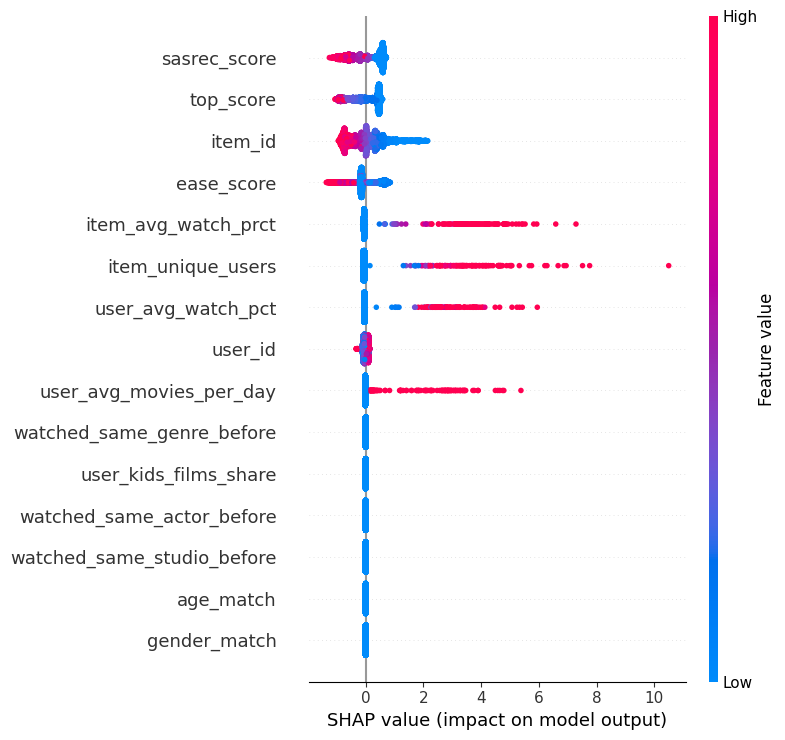

In [192]:
import shap

explainer = shap.TreeExplainer(model)
X_sample = val_stage_2_2.drop(columns=['label']).iloc[:10000]

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)

Как можно заметить самыми полезными признаками оказались следующие:
- Cредний процент просмотра фильма
- Cредний процент просмотров фильмов пользователем
- Количество уникальных пользователей посмотревших фильм
- Среднее количество просматриваемых пользователем фильмов в день
- item_id
- user_id
- scores

В целом, довольно ожидаемо увидеть именно эти признаки. Они имеют довольно мало пропущенных значений, что нельзя сказать о тех признаках, которые по графику shap не важны.

На подготовку данных тест к сожалению уже нет времени(((


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!